# <center>Проект 4: классификация

## Постановка задачи

Банки хранят огромные объёмы информации о своих клиентах. Эти данные можно использовать для того, чтобы оставаться на связи с клиентами и индивидуально ориентировать их на подходящие именно им продукты или банковские предложения.

Обычно с выбранными клиентами связываются напрямую через разные каналы связи: лично (например, при визите в банк), по телефону, по электронной почте, в мессенджерах и так далее. Этот вид маркетинга называется прямым маркетингом. На самом деле, прямой маркетинг используется для взаимодействия с клиентами в большинстве банков и страховых компаний. Но, разумеется, проведение маркетинговых кампаний и взаимодействие с клиентами — это трудозатратно и дорого.



**Бизнес-задача:** определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.

**Техническая задача для нас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.


---

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов



Данные о клиентах банка:

       * age (возраст);
       * job (сфера занятости);
       * marital (семейное положение);
       * education (уровень образования);
       * default (имеется ли просроченный кредит);
       * housing (имеется ли кредит на жильё);
       * loan (имеется ли кредит на личные нужды);
       * balance (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

       * contact (тип контакта с клиентом);
       * month (месяц, в котором был последний контакт);
       * day (день, в который был последний контакт);
       * duration (продолжительность контакта в секундах).

Прочие признаки:

       * campaign (количество контактов с этим клиентом в течение текущей кампании);
       * pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
       * previous (количество контактов до текущей кампании)
       * poutcome (результат прошлой маркетинговой кампании).

И, разумеется, наша целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.


#### Загрузка данных

In [104]:
# Ссылка на датасет: https://drive.google.com/file/d/19SiCLXAbNc1nM2zWe9SWCoxBjKuzBnIV/view?usp=share_link
df = pd.read_csv('https://raw.githubusercontent.com/AlexandrBorisov1/2_7/master/bank_fin.csv', sep = ';')

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [105]:
# Удалим дупликаты
df = df.drop_duplicates(ignore_index=True)
print(f'Результирующее число записей: {df.shape[0]}')

Результирующее число записей: 11162


#### Обработка пропусков

In [106]:
# Взглянем на пропуски
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

Явные пропуски только в признаке "balance".

In [107]:
# Поищем скрытые пропуски
omissions = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
for i in omissions:
  print(i+': ',df[i].unique(),'\n')

job:  ['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student'] 

marital:  ['married' 'single' 'divorced'] 

education:  ['secondary' 'tertiary' 'primary' 'unknown'] 

default:  ['no' 'yes'] 

housing:  ['yes' 'no'] 

loan:  ['no' 'yes'] 

contact:  ['unknown' 'cellular' 'telephone'] 

month:  ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep'] 

poutcome:  ['unknown' 'other' 'failure' 'success'] 



In [108]:
# Количество значений "unknown" в признаках
unknown_ommissions = ['job', 'education', 'contact', 'poutcome']
for i in unknown_ommissions:
  print(i+'\n'+'-'*25+'\n',df[i].value_counts(),'\n')

job
-------------------------
 management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64 

education
-------------------------
 secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64 

contact
-------------------------
 cellular     8042
unknown      2346
telephone     774
Name: contact, dtype: int64 

poutcome
-------------------------
 unknown    8326
failure    1228
success    1071
other       537
Name: poutcome, dtype: int64 



Изменим значение "unknown" на моду, в признаках job, education и contact

In [109]:
df.loc[df['job'] == 'unknown', 'job'] = df['job'].mode()[0]
df.loc[df['education'] == 'unknown', 'education'] = df['education'].mode()[0]
df.loc[df['contact'] == 'unknown', 'contact'] = df['contact'].mode()[0]

Признак "balance" необходимо перевести в числовой формат

In [110]:
df['balance'] = df['balance'].apply(lambda x: float(str(x).replace(' ', '').replace('$', '').replace(',', '.')))

In [111]:
# И обработаем пропуски в признаке balance , заменив их на медианные значения по данному признаку
df.loc[df['balance'].isnull() == True, 'balance'] = df['balance'].median()

In [112]:
df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,cellular,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,cellular,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,cellular,5,may,1389,1,-1,0,unknown,yes


#### Обработка выбросов

In [113]:
df['previous'].unique()

array([ 0,  1,  4,  2,  3, 10,  7,  9,  5, 29,  6, 13, 17,  8, 11, 30, 22,
       58, 21, 14, 26, 12, 19, 55, 23, 15, 20, 27, 16, 41, 40, 28, 18, 37])

Проверим на выбросы числовые признаки: age, balance, day, duration, campaign, pdays, previous.

In [114]:
print('age: ',df['age'].unique(),'\n')
print('day: ',df.day.unique())

age:  [59 56 41 55 54 42 60 37 28 38 30 29 46 31 35 32 49 43 26 40 33 23 48 45
 36 52 53 39 57 51 44 24 50 27 34 47 25 58 61 68 75 22 69 66 85 72 90 67
 71 21 74 65 62 83 70 76 77 19 73 63 20 78 95 64 79 82 18 86 84 87 92 81
 80 93 88 89] 

day:  [ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 28 29 30  2  3  4 11 17
 18 24  1 10 22 25 31]


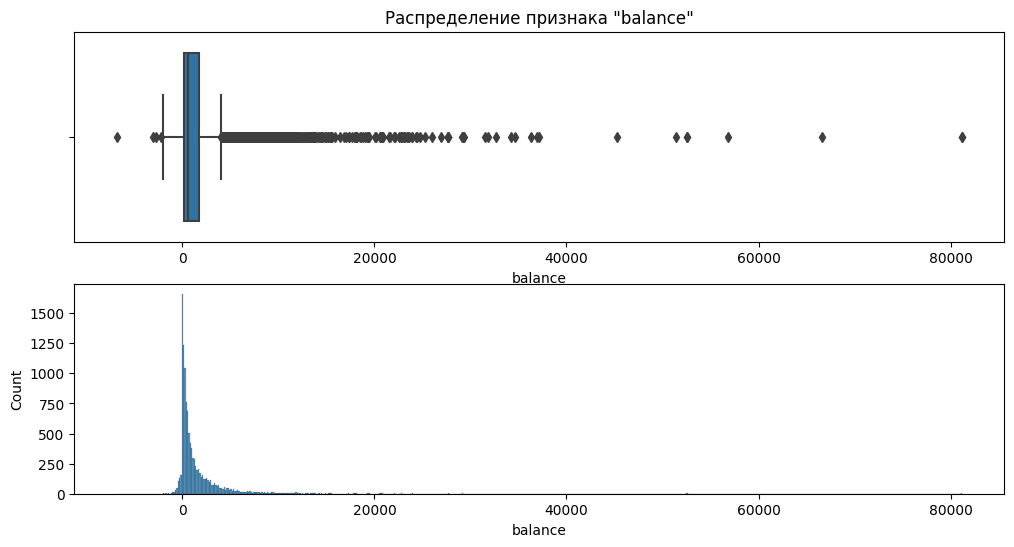

In [115]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(12, 6))
balance_hist = sns.histplot(df, x='balance', ax=ax[1])
balance_plot = sns.boxplot(df, x='balance', ax=ax[0])
balance_plot.set_title('Распределение признака "balance"');

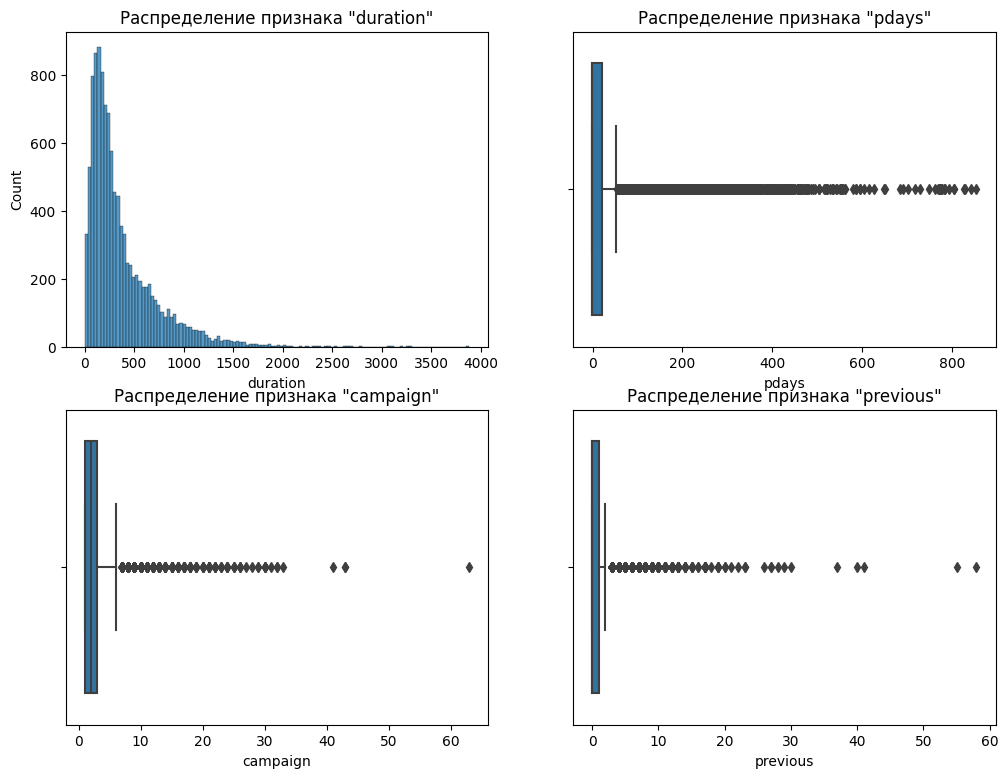

In [116]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 9))

duration_plot = sns.histplot(df, x='duration', ax=ax[0][0])
duration_plot.set_title('Распределение признака "duration"')
pdays_plot = sns.boxplot(df, x='pdays', ax=ax[0][1])
pdays_plot.set_title('Распределение признака "pdays"')
campaign_plot = sns.boxplot(df, x='campaign', ax=ax[1][0])
campaign_plot.set_title('Распределение признака "campaign"')
previous_plot = sns.boxplot(df, x='previous', ax=ax[1][1])
previous_plot.set_title('Распределение признака "previous"');

Выбросы есть, везде и много. Несовсем понятен признак "pdays" и его значение равное -1 которое соответствует 80% всего распределения.

Пока оставим всё как есть, потом по эксперементируем.

In [117]:
'''def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return cleaned, lower_bound, upper_bound

clean_data, lower_bound, upper_bound = outliers_iqr(df, 'balance')
print(lower_bound, '\n', upper_bound)'''

"def outliers_iqr(data, feature):\n    x = data[feature]\n    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),\n    iqr = quartile_3 - quartile_1\n    lower_bound = quartile_1 - (iqr * 1.5)\n    upper_bound = quartile_3 + (iqr * 1.5)\n    outliers = data[(x < lower_bound) | (x > upper_bound)]\n    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]\n    return cleaned, lower_bound, upper_bound\n\nclean_data, lower_bound, upper_bound = outliers_iqr(df, 'balance')\nprint(lower_bound, '\n', upper_bound)"

## Часть 2:  Разведывательный анализ

no     5873
yes    5289
Name: deposit, dtype: int64


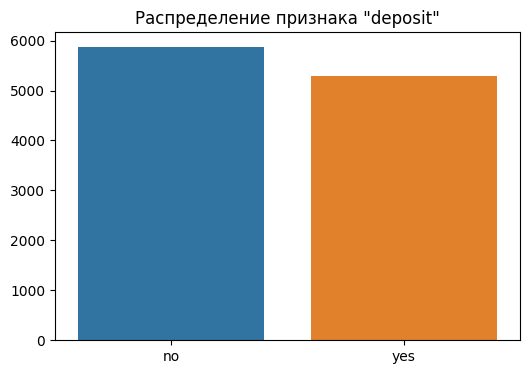

In [118]:
# Проверим сбалансированность целевого признака
fig, ax = plt.subplots(figsize=(6, 4))
depo_freq = df['deposit'].value_counts()
print(depo_freq)
barplot = sns.barplot(x=depo_freq.keys(), y=depo_freq.values)
barplot.set_title('Распределение признака "deposit"');

In [119]:
# Описательные статистики для количественных переменных
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1526.936033,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3224.829691,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,123.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1699.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


1. Сравнивая среднее значение с медианой можно сказать, что в признаках "balance" и "pdays" имеются выбросы
2. В признаках "pdays" и "previous" более 70% значений равны -1 и 0 соответственно.

In [120]:
# Описательные статистики для категориальных переменных
cat_features = ['job', 'marital', 'education', 'default', 'housing',
                'loan', 'contact', 'month', 'poutcome', 'deposit']

df[cat_features].describe()

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,11162,11162,11162,11162,11162,11162,11162,11162,11162,11162
unique,11,3,3,2,2,2,2,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2636,6351,5973,10994,5881,9702,10388,2824,8326,5873


1. Признаки "default", "housing", "loan", "contact" и "deposit" являются бинарными, поэтому закодируем их единицами и нулями.
2. Признаки "job", "marital", "education", "month" и "poutcome" имеют мало уникальных значений, поэтому закодируем их one_hot_encoding методом.
3. Признак "default" на 98% состоит из значений 'no', следовательно он неинформативен и подлежит удалению

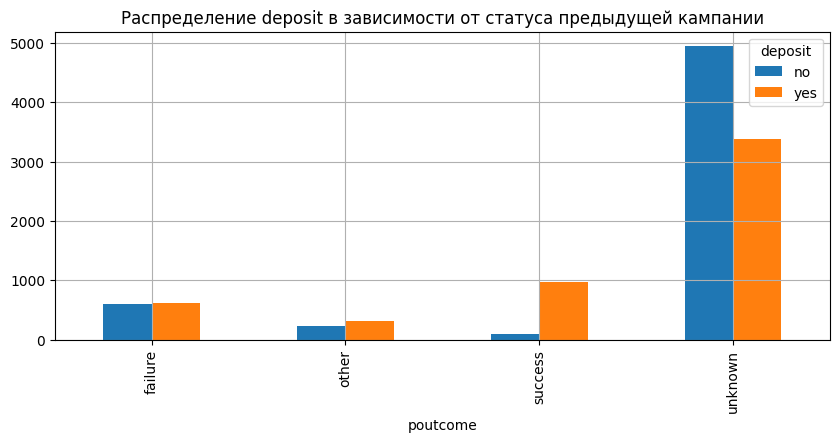

In [121]:
# Проверим, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
d = df.groupby(by='poutcome')['deposit'].value_counts().unstack()
d.plot(kind='bar', grid=True, figsize=(10, 4), title='Распределение deposit в зависимости от статуса предыдущей кампании');

Судя по результатам можно сказать что, если в предыдущей кампании был успех, то клиент вероятнее всего откроет депозит.

In [122]:
# Проверим, в каком месяце чаще всего отказывались и соглашались от предложения открыть депозит
df.groupby(by='month')['deposit'].value_counts(normalize=False).unstack()

deposit,no,yes
month,,
apr,346,577
aug,831,688
dec,10,100
feb,335,441
jan,202,142
jul,887,627
jun,676,546
mar,28,248
may,1899,925


Как можно увидеть, вероятнее всего клиент согласится с предложением в феврале, марте, апреле, сентябре, октбре  и декабре.

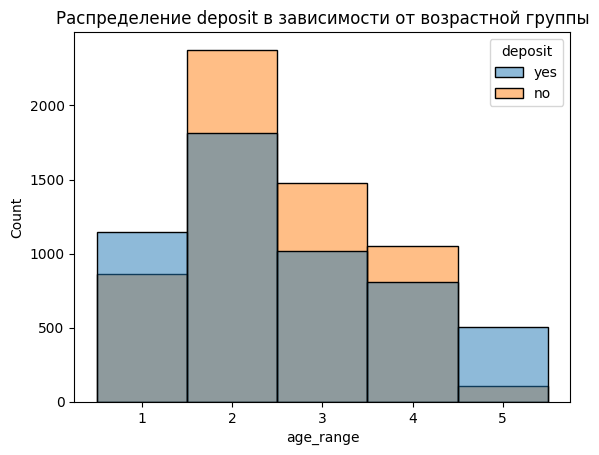

In [123]:
# Cоздадим возрастные группы и определим, в каких группах более склонны открывать депозит.
range_list = [0, 30, 40, 50, 60, 100]
df['age_range'] = 0
for i in range(len(range_list)-1):
  df.loc[(df['age'] > range_list[i]) & (df['age'] <= range_list[i+1]), 'age_range'] = i+1

age_plot = sns.histplot(data=df, x='age_range', hue='deposit', bins=10, discrete=True)
age_plot.set_title('Распределение deposit в зависимости от возрастной группы');

Более склонны открывать депозит клиенты младше 30 и старше 60 лет.

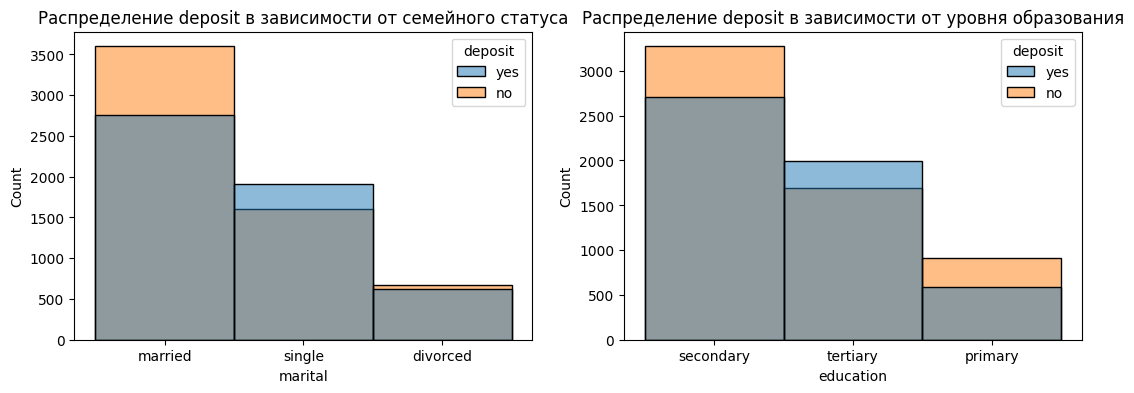

In [124]:
# Визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса и уровня образования.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))
mari_plot = sns.histplot(data=df, x='marital', hue='deposit', ax=ax[0])
mari_plot.set_title('Распределение deposit в зависимости от семейного статуса')
education_plot = sns.histplot(data=df, x='education', hue='deposit', ax=ax[1])
education_plot.set_title('Распределение deposit в зависимости от уровня образования');

К открытию депозита более склонны одиночки с высшим образованием.

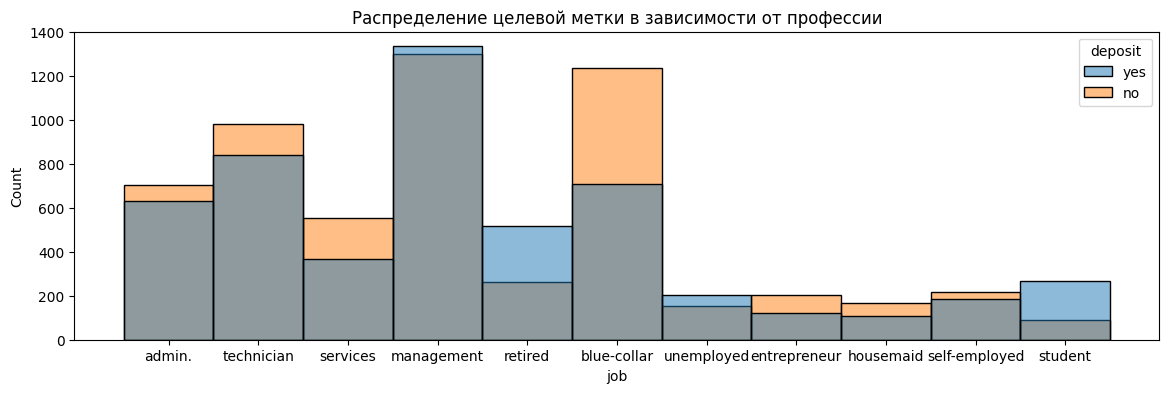

In [125]:
# Визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
fig, ax = plt.subplots(figsize=(14, 4))
job_plot = sns.histplot(data=df, x='job', hue='deposit')
job_plot.set_title('Распределение целевой метки в зависимости от профессии');

Как видно, товарищи из рабочего класса неочень хотят открывать депозит, а вот студенты и пенсионеры, напротив, активно соглашаются на данное предложение.

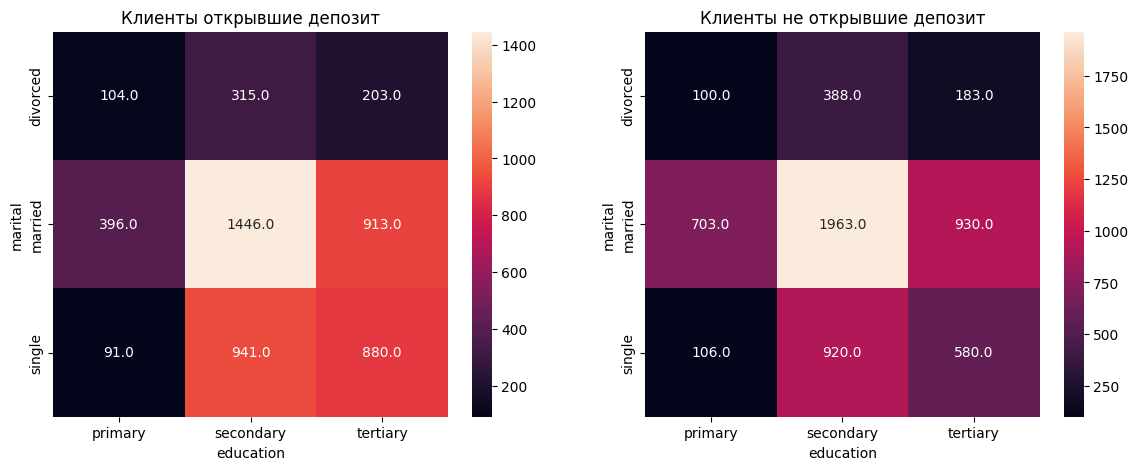

In [126]:
# Построим сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
yes_ptable = pd.pivot_table(data=df[df['deposit'] == 'yes'], values='deposit', index='marital', columns='education', aggfunc='count')
no_ptable = pd.pivot_table(data=df[df['deposit'] == 'no'], values='deposit', index='marital', columns='education', aggfunc='count')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
yes_plot = sns.heatmap(yes_ptable, annot=True, ax=ax[0], fmt='.1f')
yes_plot.set_title('Клиенты открывшие депозит')
no_plot = sns.heatmap(no_ptable, annot=True, ax=ax[1], fmt='.1f')
no_plot.set_title('Клиенты не открывшие депозит');

---

## Часть 3: преобразование данных

In [127]:
data = df.copy()
data.reset_index(inplace=True)
data.head()

,index,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_range
0,0,59,admin.,married,secondary,no,2343.0,yes,no,cellular,5,may,1042,1,-1,0,unknown,yes,4
1,1,56,admin.,married,secondary,no,45.0,no,no,cellular,5,may,1467,1,-1,0,unknown,yes,4
2,2,41,technician,married,secondary,no,1270.0,yes,no,cellular,5,may,1389,1,-1,0,unknown,yes,3
3,3,55,services,married,secondary,no,2476.0,yes,no,cellular,5,may,579,1,-1,0,unknown,yes,4
4,4,54,admin.,married,tertiary,no,184.0,no,no,cellular,5,may,673,2,-1,0,unknown,yes,4


In [128]:
# Преобразуем уровни образования
le = LabelEncoder()
le_education = pd.Series(le.fit_transform(data['education']), name='education_en')
data = pd.concat([data, le_education], axis=1)

In [129]:
# Преобразуем бинарные переменные в представление из нулей и единиц
data['deposit'] = data['deposit'].apply(lambda d: 1 if d == 'yes' else 0)
data['default'] = data['default'].apply(lambda d: 1 if d == 'yes' else 0)
data['housing'] = data['housing'].apply(lambda d: 1 if d == 'yes' else 0)
data['loan'] = data['loan'].apply(lambda d: 1 if d == 'yes' else 0)

In [130]:
#!pip install category_encoders

In [131]:
# Однократное кодирование категориальных переменных
import category_encoders as ce
dummy_list = ['job', 'marital', 'contact', 'month', 'poutcome']

for f in dummy_list:
  encoder = ce.OneHotEncoder(cols=[f], use_cat_names=True)
  dum = encoder.fit_transform(data[f])
  data = pd.concat([data, dum], axis=1)


In [132]:
data = data.drop(['index', 'education'], axis=1)

In [133]:
data.head()

,age,job,marital,default,balance,housing,loan,contact,day,month,...,month_dec,month_jan,month_feb,month_mar,month_apr,month_sep,poutcome_unknown,poutcome_other,poutcome_failure,poutcome_success
0,59,admin.,married,0,2343.0,1,0,cellular,5,may,...,0,0,0,0,0,0,1,0,0,0
1,56,admin.,married,0,45.0,0,0,cellular,5,may,...,0,0,0,0,0,0,1,0,0,0
2,41,technician,married,0,1270.0,1,0,cellular,5,may,...,0,0,0,0,0,0,1,0,0,0
3,55,services,married,0,2476.0,1,0,cellular,5,may,...,0,0,0,0,0,0,1,0,0,0
4,54,admin.,married,0,184.0,0,0,cellular,5,may,...,0,0,0,0,0,0,1,0,0,0


#### Проверим данные на мультиколлинеарность и корреляцию с целевым признаком

In [137]:
# Построим корреляционную матрицу и оценим данные на предмет наличия мультиколлинеарности
num_cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 'deposit']
cat_cols = ['job', 'marital', 'default', 'housing', 'loan',
       'contact', 'month', 'day',
       'poutcome', 'age_range', 'education_en', 'job_admin.',
       'job_technician', 'job_services', 'job_management', 'job_retired',
       'job_blue-collar', 'job_unemployed', 'job_entrepreneur',
       'job_housemaid', 'job_self-employed', 'job_student', 'marital_married',
       'marital_single', 'marital_divorced',
       'contact_cellular', 'contact_telephone', 'month_may', 'month_jun',
       'month_jul', 'month_aug', 'month_oct', 'month_nov', 'month_dec',
       'month_jan', 'month_feb', 'month_mar', 'month_apr', 'month_sep',
       'poutcome_unknown', 'poutcome_other', 'poutcome_failure',
       'poutcome_success', 'deposit']


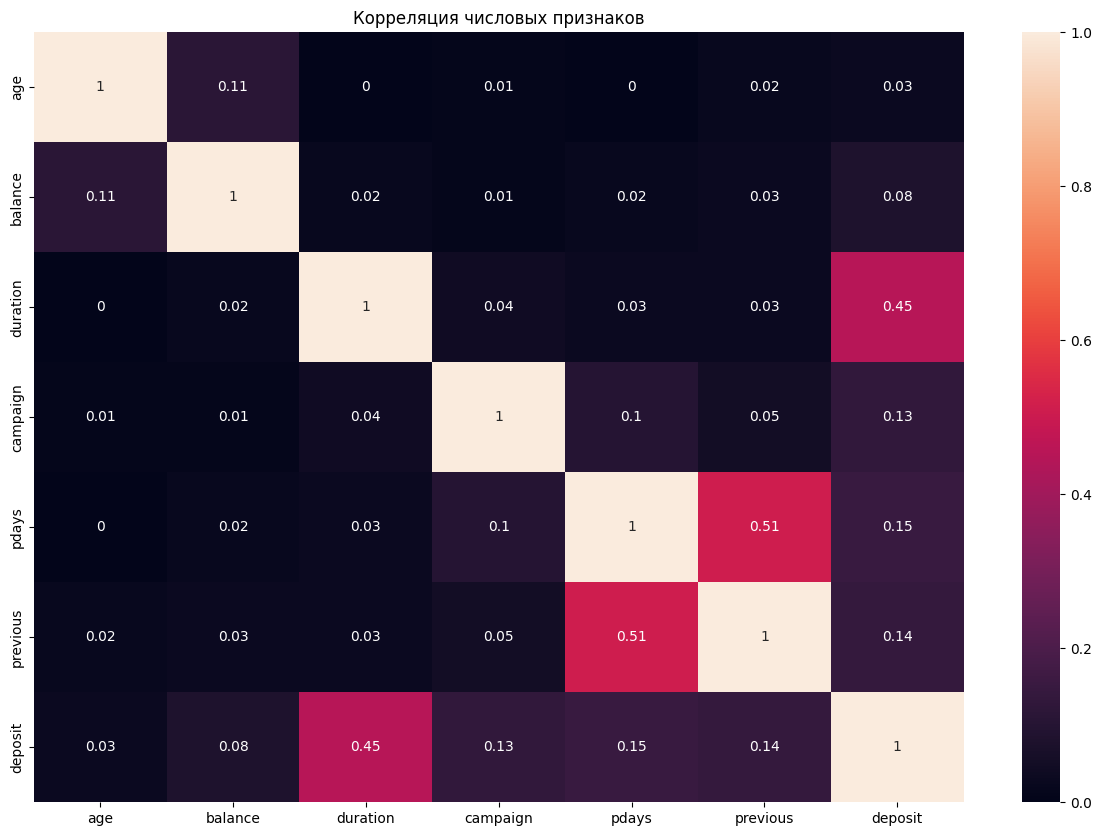

In [138]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
num_corr_plot = sns.heatmap(data[num_cols].corr().abs().round(2), annot=True);
num_corr_plot.set_title('Корреляция числовых признаков');

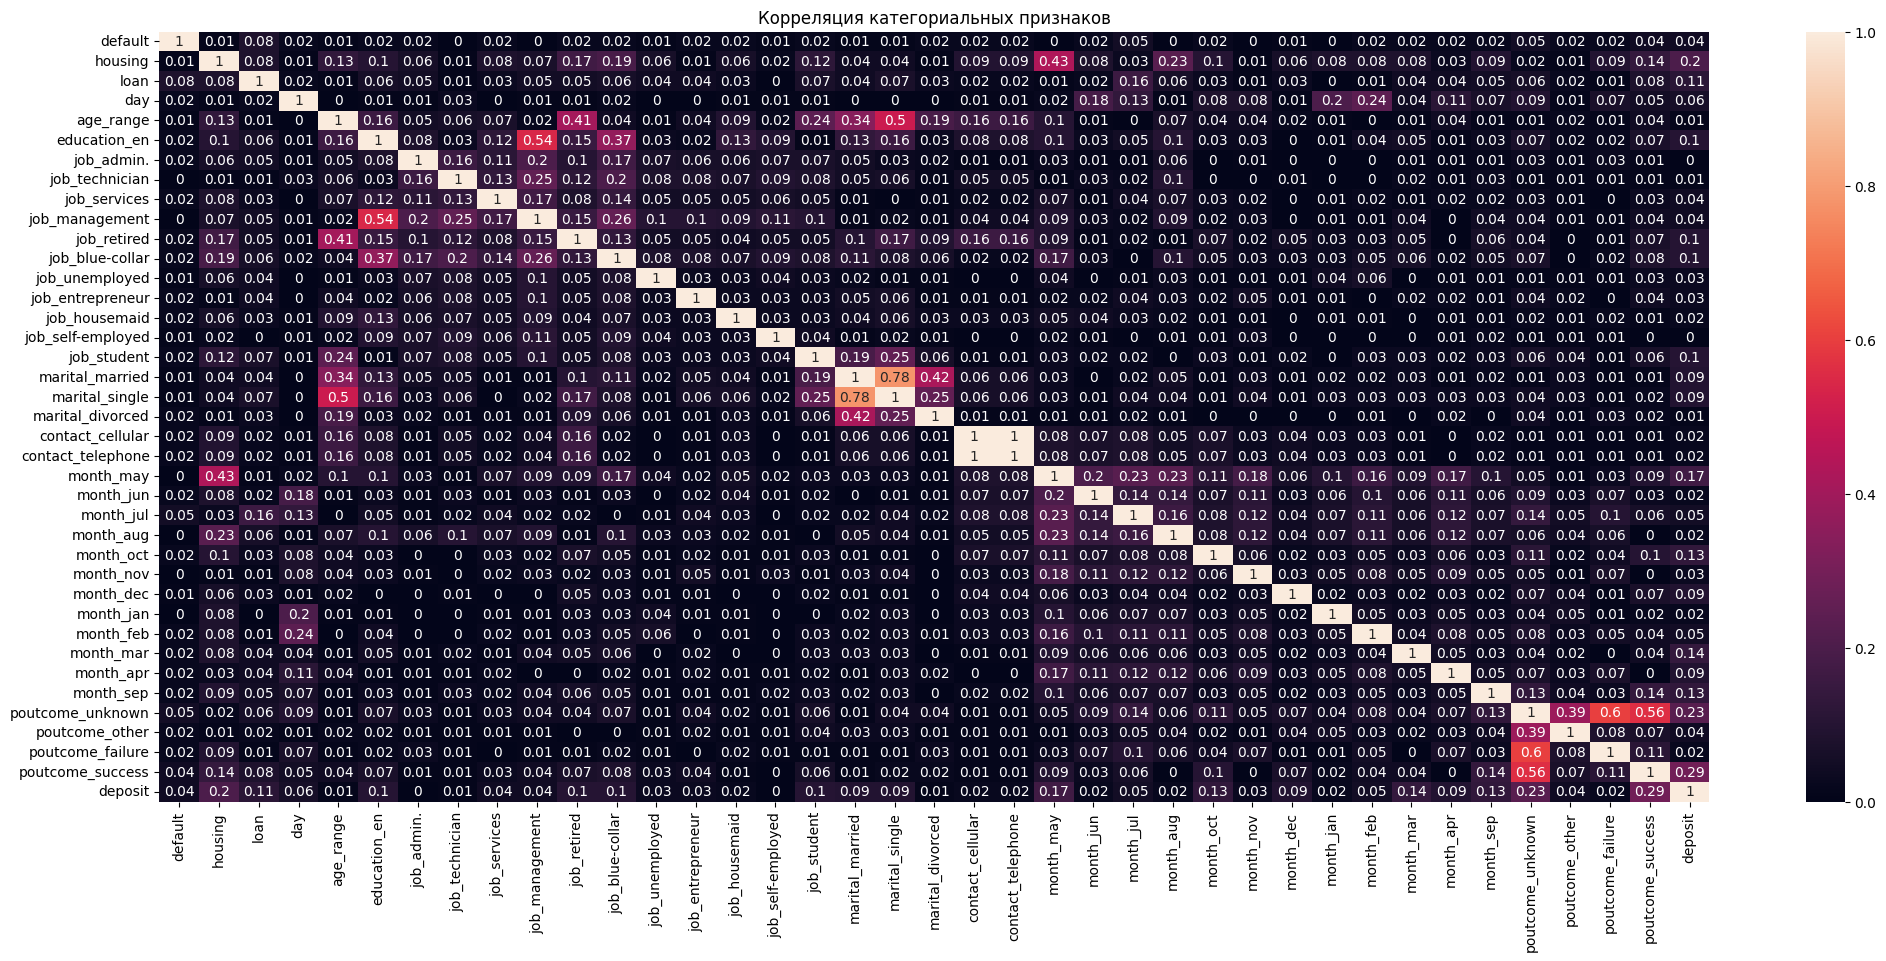

In [139]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
cat_corr_plot = sns.heatmap(data[cat_cols].corr(method='spearman').abs().round(2), annot=True);
cat_corr_plot.set_title('Корреляция категориальных признаков');

Мультиколлинеарности не обнаружено.

Топ 10 коррелирующих с deposit признаков: duration, poutcome_success, poutcome_unknown, housing, month_may, pdays, previous, month_mar, campaign, month_oct.

In [140]:
del_columns = ['job', 'marital', 'contact', 'month', 'poutcome']
data = data.drop(del_columns, axis=1)

In [141]:
X = data.drop(['deposit'], axis=1)
y = data['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [144]:
# С помощью SelectKBest отберём 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)

selector.get_feature_names_out()

array(['housing', 'loan', 'duration', 'campaign', 'pdays', 'previous',
       'education_en', 'job_blue-collar', 'job_student', 'month_may',
       'month_oct', 'month_mar', 'month_sep', 'poutcome_unknown',
       'poutcome_success'], dtype=object)

In [145]:
# Нормализуем данные с помощью minmaxscaler
from sklearn.preprocessing import MinMaxScaler

df = data[['housing', 'loan', 'duration', 'campaign', 'pdays', 'previous',
       'education_en', 'job_blue-collar', 'job_student', 'month_may',
       'month_oct', 'month_mar', 'month_sep', 'poutcome_unknown',
       'poutcome_success', 'deposit']]

X = df.drop(['deposit'], axis=1)
y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

In [146]:
# Обучим логистическую регрессию и рассчитаем метрики качества
log_reg = linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)

In [147]:
print(f"Accuracy на тестовой выборке: {round(metrics.accuracy_score(y_test, y_pred), 3)}")

Accuracy на тестовой выборке: 0.809


In [152]:
# Обучим решающие деревья
dtree_cassifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=8)
dtree_cassifier.fit(X_train_scaled, y_train)

y_train_pred = dtree_cassifier.predict(X_train_scaled)
y_test_pred = dtree_cassifier.predict(X_test_scaled)

In [153]:
print(f"Accuracy на тренировочной выборке: {round(metrics.accuracy_score(y_train, y_train_pred), 3)}")
print(f"Accuracy на тестовой выборке: {round(metrics.accuracy_score(y_test, y_test_pred), 3)}")

Accuracy на тренировочной выборке: 0.824
Accuracy на тестовой выборке: 0.803


#### Оптимизация гиперпараметров

In [157]:
from sklearn.model_selection import GridSearchCV

param_grid = {
              'min_samples_leaf': list(range(2, 11)),
              'max_depth': list(range(3, 15))
              }

grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(criterion='entropy', random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs = -1
)
grid_search_tree.fit(X_train_scaled, y_train)
y_train_pred = grid_search_tree.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = grid_search_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

f1_score на обучающем наборе: 0.82
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'max_depth': 10, 'min_samples_leaf': 9}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

In [163]:
# Обучим на наших данных случайный лес
rand_forest = ensemble.RandomForestClassifier(n_estimators=100,
                                              criterion='gini',
                                              min_samples_leaf=5,
                                              max_depth=10,
                                              random_state=42)
rand_forest.fit(X_train_scaled, y_train)
y_train_pred = rand_forest.predict(X_train_scaled)
y_test_pred = rand_forest.predict(X_test_scaled)

In [164]:
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1938
           1       0.80      0.84      0.82      1746

    accuracy                           0.83      3684
   macro avg       0.83      0.83      0.83      3684
weighted avg       0.83      0.83      0.83      3684



In [165]:
# Используем для классификации градиентный бустинг и сравним качество со случайным лесом
gbc = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gbc.fit(X_train_scaled, y_train)
y_train_pred = gbc.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = gbc.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.86
f1_score на тестовом наборе: 0.82


In [166]:
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1938
           1       0.80      0.84      0.82      1746

    accuracy                           0.82      3684
   macro avg       0.82      0.82      0.82      3684
weighted avg       0.82      0.82      0.82      3684



#### Стекинг

In [167]:
# Объеденим уже известные нам алгоритмы с помощью стекинга
estimators = [
    ('lr', log_reg),
    ('dt',  dtree_cassifier),
    ('gbc', gbc)
]

reg = ensemble.StackingClassifier(
    estimators=estimators,                            #базовые модели в стекинге
    final_estimator=linear_model.LogisticRegression(  #метамодель
        random_state=42
    )
)
# Обучаем модель
reg.fit(X_train_scaled, y_train)

y_train_pred = reg.predict(X_train_scaled)
print('precision_score на обучающем наборе: {:.2f}'.format(metrics.precision_score(y_train, y_train_pred)))

y_test_pred = reg.predict(X_test_scaled)
print('precision_score на тестовом наборе: {:.2f}'.format(metrics.precision_score(y_test, y_test_pred)))

precision_score на обучающем наборе: 0.84
precision_score на тестовом наборе: 0.81


<Axes: >

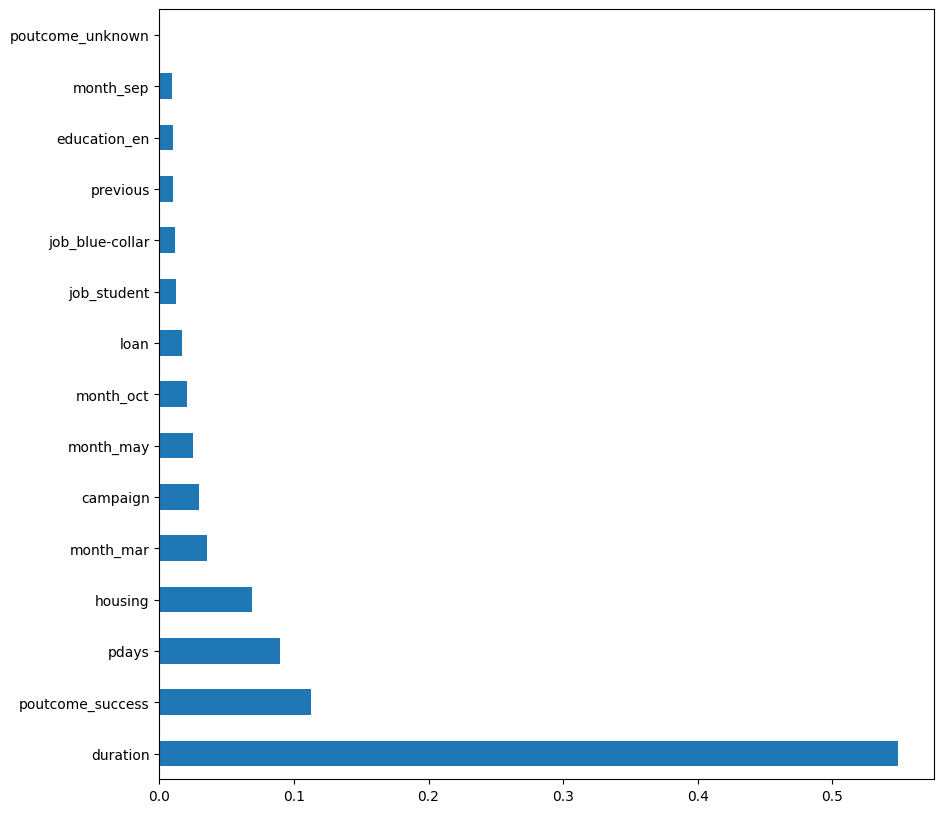

In [168]:
# Оценим, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(gbc.feature_importances_, index=X.columns)
feat_importances.nlargest(40).plot(kind='barh')

#### Оптимизируем гиперпараметры с помощью Optuna

In [169]:
#!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.3 MB/s eta 0:00:00


In [170]:
import optuna
from sklearn.model_selection import cross_val_score

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 5, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  score = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

  return score

In [171]:
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-10-23 15:39:41,376] A new study created in memory with name: RandomForestClassifier
[I 2023-10-23 15:39:49,394] Trial 0 finished with value: 0.7888591151744123 and parameters: {'n_estimators': 200, 'max_depth': 13, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.7888591151744123.
[I 2023-10-23 15:39:52,968] Trial 1 finished with value: 0.7474006645113714 and parameters: {'n_estimators': 126, 'max_depth': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7888591151744123.
[I 2023-10-23 15:39:58,642] Trial 2 finished with value: 0.7920275261367745 and parameters: {'n_estimators': 173, 'max_depth': 20, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.7920275261367745.
[I 2023-10-23 15:40:04,559] Trial 3 finished with value: 0.7913665485772731 and parameters: {'n_estimators': 122, 'max_depth': 18, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.7920275261367745.
[I 2023-10-23 15:40:09,989] Trial 4 finished with value: 0.789256562725629 and parameters: {'n_es

In [172]:
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)

y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Наилучшие значения гиперпараметров {'n_estimators': 163, 'max_depth': 25, 'min_samples_leaf': 6}
f1_score на обучающем наборе: 0.80
f1_score на тестовом наборе: 0.82


In [173]:
print('accuracy_score на тестовом наборе: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

accuracy_score на тестовом наборе: 0.82


---

## Заключение

Благодаря оптимизации гиперпараметров модели RandomForestClassifier с помощью Optuna, удалось добиться лучшей метрики f1-score = 0.82, без переобучения модели.

Честно говоря, очень странный проект, результат которого сильно конфликтует с поставленной бизнес-задачей и абсолютно НЕ помогает бизнесу сэкономить ресурсы. Дело в том, что для сохранения ресурсов нам надо классифицировать клиента до контакта с ним(что-бы узнать склонен он к открытию депозита или нет) , иначе получается, что мы уже тратим ресурсы на контакт и дальнейшая классификация не имеет никакого смысла. По результату и длительности контакта, сразу станет ясно воспользуется клиент услугой банка или нет, ведь если клиенту не интересено предложение, то он долго разговаривать небудет.
Для того чтобы появилась ценность этого проекта, необходимо полностью удалить данные связанные с последним контактом в контексте текущей маркетинговой кампании. В таком случае метрики сразу проваляться вниз, т.к. наибольший вклад даёт продолжительность контакта.